# GA Project 4: West Nile Virus
by: Nicholas Lim, Kwek Jun Hong, Malcolm Lau
***

## Notebook organisation
- Notebook 1: Data Cleaning, EDA and Feature Engineering 
- **Notebook 2: Model Tuning, Evaluation and Cost Benefit Analysis (current notebook)**


# Imports

In [1]:
# fabulous four
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import re
import datetime as dt
import warnings

warnings.filterwarnings('ignore')


# Machine Learning Libraries
from sklearn.model_selection import train_test_split , GridSearchCV
from sklearn.metrics import f1_score , recall_score , accuracy_score , precision_score , roc_auc_score , confusion_matrix , plot_roc_curve
from sklearn.ensemble import RandomForestClassifier , GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imblearnpipe
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

# Load Data

In [2]:
train = pd.read_csv('data/train_cleaned.csv')
train.head()

,date,species,latitude,longitude,wnv_present,tavg,dew_point,precip_total,stn_pressure,avg_speed,year,month,week_of_year,daylight_hours,r_humidity
0,2007-05-29,CULEX PIPIENS/RESTUANS,41.954690,-87.800991,0,75.5,58.5,0.0,29.415,6.95,2007.0,5.0,22.0,14.93,55.615
1,2007-05-29,CULEX RESTUANS,41.954690,-87.800991,0,75.5,58.5,0.0,29.415,6.95,2007.0,5.0,22.0,14.93,55.615
2,2007-05-29,CULEX RESTUANS,41.994991,-87.769279,0,75.5,58.5,0.0,29.415,6.95,2007.0,5.0,22.0,14.93,55.615
3,2007-05-29,CULEX PIPIENS/RESTUANS,41.974089,-87.824812,0,75.5,58.5,0.0,29.415,6.95,2007.0,5.0,22.0,14.93,55.615
4,2007-05-29,CULEX RESTUANS,41.974089,-87.824812,0,75.5,58.5,0.0,29.415,6.95,2007.0,5.0,22.0,14.93,55.615


In [3]:
test = pd.read_csv('data/test_cleaned.csv')
test.head()

,date,species,latitude,longitude,tavg,dew_point,precip_total,stn_pressure,avg_speed,year,month,week_of_year,daylight_hours,r_humidity
0,2008-06-11,CULEX PIPIENS/RESTUANS,41.95469,-87.800991,75.0,55.5,0.0,29.31,10.2,2008.0,6.0,24.0,15.17,50.79
1,2008-06-11,CULEX RESTUANS,41.95469,-87.800991,75.0,55.5,0.0,29.31,10.2,2008.0,6.0,24.0,15.17,50.79
2,2008-06-11,CULEX PIPIENS,41.95469,-87.800991,75.0,55.5,0.0,29.31,10.2,2008.0,6.0,24.0,15.17,50.79
3,2008-06-11,CULEX SALINARIUS,41.95469,-87.800991,75.0,55.5,0.0,29.31,10.2,2008.0,6.0,24.0,15.17,50.79
4,2008-06-11,CULEX TERRITANS,41.95469,-87.800991,75.0,55.5,0.0,29.31,10.2,2008.0,6.0,24.0,15.17,50.79


# Modeling
***
The following models would be used:

|                |                  Models                 |
|:--------------:|:---------------------------------------:|
| Baseline Model |               BernoulliNB               |
|     Model 1    |            Logistic Regression          |
|     Model 2    |          Random Forest Classifier       |
|     Model 3    |        Gradient Boosting Classifier     |
|     Model 4    |              XGBoost Classifier         |

As we have an unbalanced classification problem, we will be using SMOTE to oversample the data to address the imbalance in the data through a pipeline and running the models afterwards. The choices of the models are a mix of tree based models and a linear model to see which model would perform the best.

## Model data preparation

### Get the X, y data

In [4]:
X = train.drop(['date', 'wnv_present'], axis = 1)
y = train['wnv_present']

In [5]:
print(X.shape)
print(y.shape)

(10506, 13)
(10506,)


In [6]:
y.value_counts(normalize = True)

0    0.947554
1    0.052446
Name: wnv_present, dtype: float64

### Train, test, split the data

In [7]:
X.columns

Index(['species', 'latitude', 'longitude', 'tavg', 'dew_point', 'precip_total',
       'stn_pressure', 'avg_speed', 'year', 'month', 'week_of_year',
       'daylight_hours', 'r_humidity'],
      dtype='object')

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, random_state = 42)

In [9]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(7879, 13)
(2627, 13)
(7879,)
(2627,)


## Modeling Functions

In [10]:
# define the numerical columns

numerical_cols = ['latitude', 'longitude', 'tavg', 'dew_point', 'precip_total',\
                  'stn_pressure', 'avg_speed', 'daylight_hours', 'r_humidity', 'year',\
                  'month', 'week_of_year']
categorical_cols = ['species']

In [11]:
# Preprocessing for numerical data
numerical_transformer = StandardScaler()

# Preprocessing for categorical data
categorical_transformer = OneHotEncoder(handle_unknown = "ignore")

# Bundle preprocessing for numerical and categorical data
transformer = ColumnTransformer(
    transformers = [
        ("num", numerical_transformer, numerical_cols),
        ("cat", categorical_transformer, categorical_cols),
    ]
)

In [12]:
# Instantiate lists to store results
init_list = []
gs_list = []

# Function to run model -- input column transformer and model
def run_model(X_train, X_test, y_train, y_test, mod, mod_params = {}, grid_search = False):
    
    # Initial dictionary to hold model results
    results = {}
  
    pipe = imblearnpipe([
        ('t', transformer),
        ('sampling', SMOTE(random_state = 42)),
        (mod, models[mod])
    ])
    
    if grid_search:
        # Instantiate list to store gridsearch results
        gs = GridSearchCV(pipe, param_grid = mod_params, cv = 5, verbose = 1, scoring = 'roc_auc', n_jobs = -2)
        gs.fit(X_train, y_train)
        pipe = gs
        
    else:
        pipe.fit(X_train, y_train)
    
    # Retrieve metrics
    predictions = pipe.predict(X_test)
    tn, fp, fn, tp = confusion_matrix(y_test, predictions).ravel()
    cm_df = pd.DataFrame(confusion_matrix(y_test, predictions), 
                            index=['Actual Negative', 'Actual Postive'], 
                            columns=['Predicted Negative', 'Predicted Postive'])
    y_test_pred_prob = pipe.predict_proba(X_test)[:,1]
    y_train_pred_prob = pipe.predict_proba(X_train)[:,1]
    
    results['model'] = mod
    results['train_auc'] = round(roc_auc_score(y_train, y_train_pred_prob),3)
    results['test_auc'] = round(roc_auc_score(y_test, y_test_pred_prob),3)
    results['precision'] = round(precision_score(y_test, predictions),3)
    results['specificity'] = round(tn / (tn + fp),3)
    results['recall'] = round(recall_score(y_test, predictions),3)
    results['f_score'] = round(f1_score(y_test, predictions),3)
    
    if grid_search:
        gs_list.append(results)
        print('---Best Parameters---')
        display(pipe.best_params_)
        
    else:
        init_list.append(results)
    
    print('Model:', models[mod])
    print('---Model Metrics---')
    display(results)
    display(cm_df)
    print(f"True Negatives: {tn}")
    print(f"False Negatives: {fn}")
    print(f"True Positives: {tp}")
    print(f"False Positives: {fp}")
        
    print()
    return pipe

In [13]:
def features_plot_lr(mod, title, X = X_train):
    """Function to plot feature importance from models"""
    col = mod.best_estimator_.steps[0][1].get_feature_names_out()
    impt = mod.best_estimator_.steps[2][1].coef_.ravel()

    temp_df = pd.DataFrame(index = col, data = impt, columns = ['features'])
    temp_df.sort_values(by = 'features').plot(kind = 'barh' , figsize = (16,9))
    plt.title(f'Feature Importance from {title}');

In [14]:
def features_plot(mod, title, X = X_train):
    """Function to plot feature importance from models"""
    col = mod.best_estimator_.steps[0][1].get_feature_names_out()
    impt = mod.best_estimator_.steps[2][1].feature_importances_

    temp_df = pd.DataFrame(index = col, data = impt, columns = ['features'])
    temp_df.sort_values(by = 'features').plot(kind = 'barh' , figsize = (16,9))
    plt.title(f'Feature Importance from {title}');

## Model Tuning


In [15]:
# Instantiate the models
models = {'nb': BernoulliNB(),
          'lr': LogisticRegression(),      
          'rf': RandomForestClassifier(random_state = 42),
          'gb': GradientBoostingClassifier(random_state = 42),
          'xgb': XGBClassifier(objective = 'binary:logistic', random_state = 42, use_label_encoder = False)
        }

### Baseline Model

We will be using Bernoulli Naive Bayer as our baseline model as we are working with a binary classification problem.

In [16]:
%%time
nb = run_model(X_train, X_test, y_train, y_test, 'nb')

Model: BernoulliNB()
---Model Metrics---


{'model': 'nb',
 'train_auc': 0.765,
 'test_auc': 0.74,
 'precision': 0.09,
 'specificity': 0.592,
 'recall': 0.725,
 'f_score': 0.159}

,Predicted Negative,Predicted Postive
Actual Negative,1473,1016
Actual Postive,38,100


True Negatives: 1473
False Negatives: 38
True Positives: 100
False Positives: 1016

Wall time: 88.8 ms


### Candidate Models Tuning

#### Logistic Regression

In [17]:
lr_params = {'sampling__sampling_strategy': ['auto'], # ['minority', 'auto']
             'sampling__k_neighbors': [7, 8, 9], # [4, 5, 6, 7, 8, 9]
             'lr__penalty' : ['l1'], #['l1', 'l2']
             'lr__max_iter' : [5000],
             'lr__solver' : ['saga'], # ['liblinear', 'saga']
             'lr__C' : [0.4, 0.6, 0.8], # [0.4, 0.6, 0.8, 1.0, 1.2]
             'lr__class_weight' : ['balanced'] # [None, 'balanced']
            }

In [18]:
%%time
lr = run_model(X_train, X_test, y_train, y_test, 'lr', lr_params, grid_search = True)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
---Best Parameters---


{'lr__C': 0.4,
 'lr__class_weight': 'balanced',
 'lr__max_iter': 5000,
 'lr__penalty': 'l1',
 'lr__solver': 'saga',
 'sampling__k_neighbors': 7,
 'sampling__sampling_strategy': 'auto'}

Model: LogisticRegression()
---Model Metrics---


{'model': 'lr',
 'train_auc': 0.797,
 'test_auc': 0.79,
 'precision': 0.112,
 'specificity': 0.677,
 'recall': 0.732,
 'f_score': 0.194}

,Predicted Negative,Predicted Postive
Actual Negative,1685,804
Actual Postive,37,101


True Negatives: 1685
False Negatives: 37
True Positives: 101
False Positives: 804

Wall time: 7 s


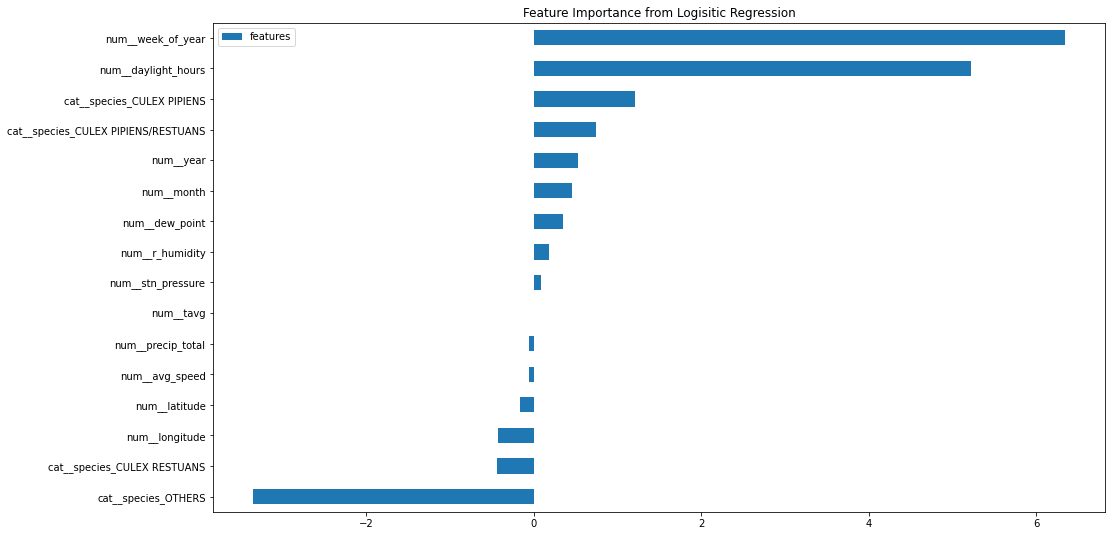

In [19]:
features_plot_lr(lr, 'Logisitic Regression')

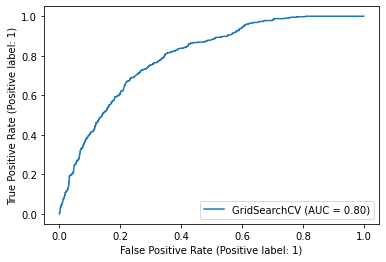

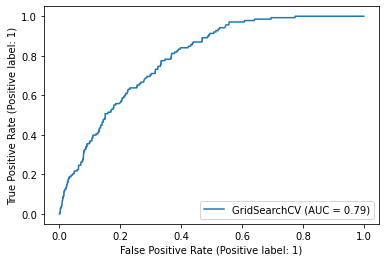

In [20]:
# plot the AUC ROC curve
plot_roc_curve(lr, X_train, y_train)
plot_roc_curve(lr, X_test, y_test);

#### Random Forest

In [21]:
rf_params = {'sampling__sampling_strategy': ['minority'], # ['minority', 'auto']
             'sampling__k_neighbors': [5],  # [4, 5, 6]
             'rf__n_estimators': [200], # [50, 100, 150, 200, 250, 300]
             'rf__min_samples_split' : [2], # [2, 4, 6, 8]
             'rf__max_depth': [9], # [5, 7, 9, 11, 13, 15]
             'rf__min_samples_leaf': [7], # [3, 5, 7, 8, 9]]
             'rf__class_weight' : ['balanced'] # ['balanced', 'balanced_subsample']
            }

In [22]:
%%time
rf = run_model(X_train, X_test, y_train, y_test, 'rf', rf_params, grid_search = True)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
---Best Parameters---


{'rf__class_weight': 'balanced',
 'rf__max_depth': 9,
 'rf__min_samples_leaf': 7,
 'rf__min_samples_split': 2,
 'rf__n_estimators': 200,
 'sampling__k_neighbors': 5,
 'sampling__sampling_strategy': 'minority'}

Model: RandomForestClassifier(random_state=42)
---Model Metrics---


{'model': 'rf',
 'train_auc': 0.894,
 'test_auc': 0.823,
 'precision': 0.158,
 'specificity': 0.816,
 'recall': 0.623,
 'f_score': 0.252}

,Predicted Negative,Predicted Postive
Actual Negative,2030,459
Actual Postive,52,86


True Negatives: 2030
False Negatives: 52
True Positives: 86
False Positives: 459

Wall time: 4.2 s


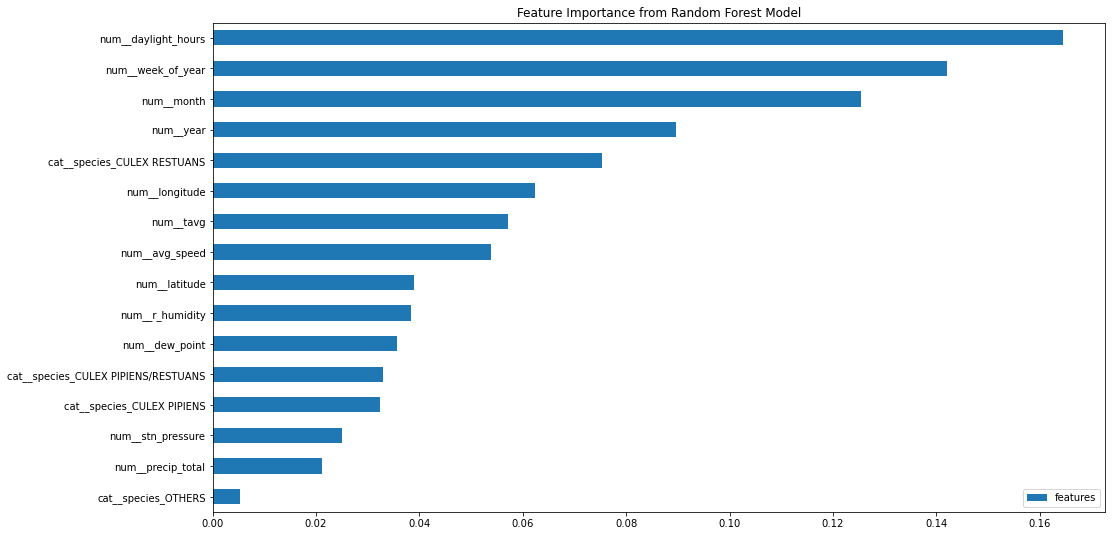

In [23]:
features_plot(rf, 'Random Forest Model')

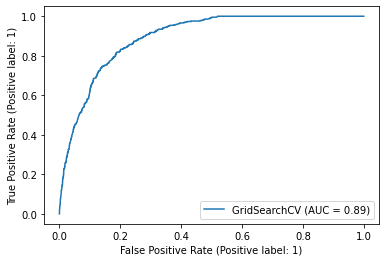

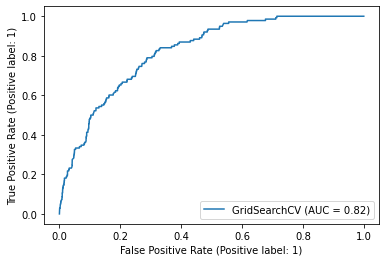

In [24]:
# plot the AUC ROC curve
plot_roc_curve(rf, X_train, y_train)
plot_roc_curve(rf, X_test, y_test);

#### Gradient Boosting Classifier

In [25]:
gb_params = {'sampling__sampling_strategy': ['minority'], # ['minority', 'auto']
             'sampling__k_neighbors': [5], # [4, 5, 6]
             'gb__max_depth': [4], # [2, 3, 4, 5]
             'gb__n_estimators': [100], # [50, 100, 150, 200]
             'gb__min_samples_leaf': [1], # [1, 3, 5]
             'gb__learning_rate': [.15] # [.08, .1, .13, .15, .17]
            }

In [26]:
%%time
gb = run_model(X_train, X_test, y_train, y_test, 'gb', gb_params, grid_search = True)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
---Best Parameters---


{'gb__learning_rate': 0.15,
 'gb__max_depth': 4,
 'gb__min_samples_leaf': 1,
 'gb__n_estimators': 100,
 'sampling__k_neighbors': 5,
 'sampling__sampling_strategy': 'minority'}

Model: GradientBoostingClassifier(random_state=42)
---Model Metrics---


{'model': 'gb',
 'train_auc': 0.901,
 'test_auc': 0.819,
 'precision': 0.19,
 'specificity': 0.883,
 'recall': 0.493,
 'f_score': 0.274}

,Predicted Negative,Predicted Postive
Actual Negative,2199,290
Actual Postive,70,68


True Negatives: 2199
False Negatives: 70
True Positives: 68
False Positives: 290

Wall time: 4.95 s


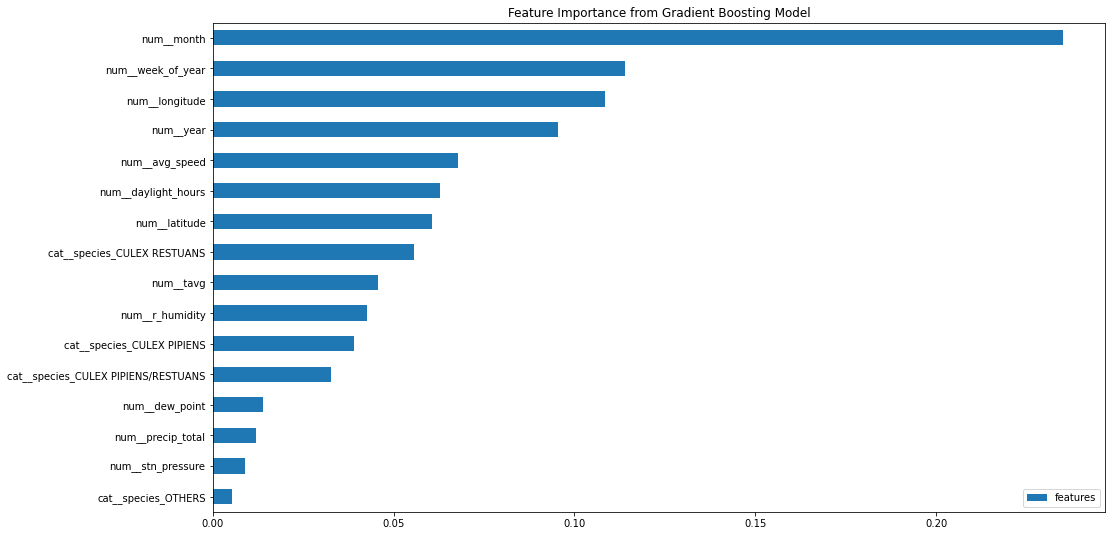

In [27]:
features_plot(gb, 'Gradient Boosting Model')

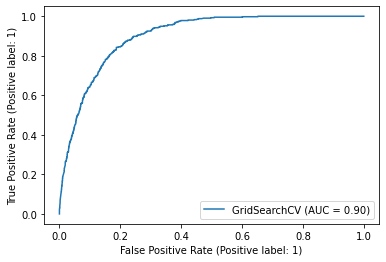

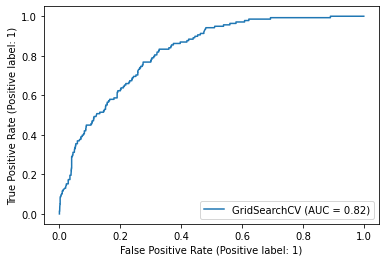

In [28]:
# plot the AUC ROC curve
plot_roc_curve(gb, X_train, y_train)
plot_roc_curve(gb, X_test, y_test);

#### XGBoost Classifier

In [29]:
xgb_params = {'sampling__sampling_strategy': ['minority'], # ['minority', 'auto']
              'sampling__k_neighbors': [4], #[2, 3, 4, 5, 6]
              'xgb__max_depth' : [4], # [2, 3, 4, 6, 8]
              'xgb__gamma' : [0], # [0 , 0.01 , 0.05]
              'xgb__learning_rate' : [0.1], # [.05, 0.1, 0.2, 0.3, 0.4]
              'xgb__n_estimators' : [40], # [20, 40, 60, 80, 100]
              'xgb__subsample' : [0.5], # [0.3, 0.5, 1]
              'xgb__colsample_bytree' : [1], # [0.5, 1]
              'xgb__lambda' : [0.5], # [0.1, 0.3, 0.5, 1, 5]
              'xgb__alpha' : [0.5] # [0, 0.5, 1]
             }

In [30]:
%%time
xgb = run_model(X_train, X_test, y_train, y_test, 'xgb', xgb_params, grid_search = True)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[10:13:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
---Best Parameters---


{'sampling__k_neighbors': 4,
 'sampling__sampling_strategy': 'minority',
 'xgb__alpha': 0.5,
 'xgb__colsample_bytree': 1,
 'xgb__gamma': 0,
 'xgb__lambda': 0.5,
 'xgb__learning_rate': 0.1,
 'xgb__max_depth': 4,
 'xgb__n_estimators': 40,
 'xgb__subsample': 0.5}

Model: XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, gamma=None, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=42, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=None, subsample=None, tree_method=None,
              use_label_encoder=False, validate_parameters=None,
              verbosity=None)
---Model Metrics---


{'model': 'xgb',
 'train_auc': 0.874,
 'test_auc': 0.831,
 'precision': 0.157,
 'specificity': 0.789,
 'recall': 0.71,
 'f_score': 0.258}

,Predicted Negative,Predicted Postive
Actual Negative,1964,525
Actual Postive,40,98


True Negatives: 1964
False Negatives: 40
True Positives: 98
False Positives: 525

Wall time: 1.74 s


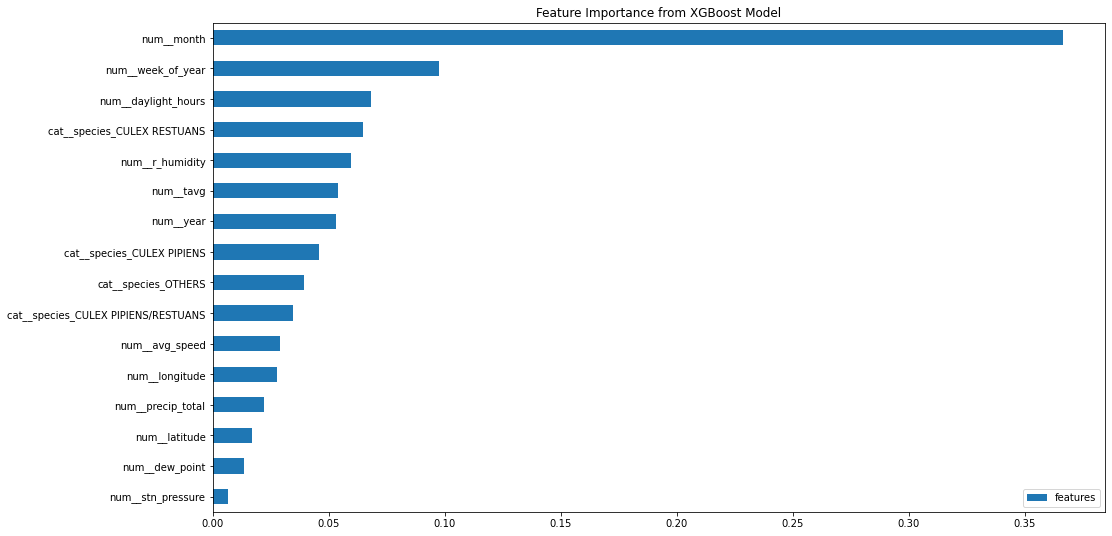

In [31]:
features_plot(xgb, 'XGBoost Model')

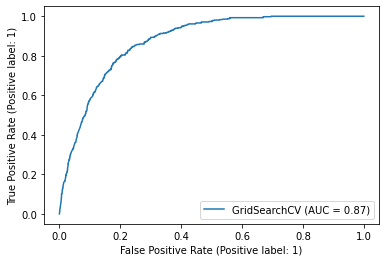

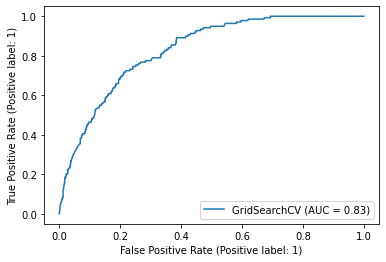

In [32]:
# plot the AUC ROC curve
plot_roc_curve(xgb, X_train, y_train)
plot_roc_curve(xgb, X_test, y_test);

### Plotting the ROC AUC Curves

In [33]:
def plot_roc_curves(model_dict, plot_top=False):
    """Function to plot all the ROC AUC curves of the models"""
    fig, ax = plt.subplots(1, 1, figsize=(12,10))
    axes = {}
    for i, m in enumerate(model_dict.keys()):
        axes[f'ax{i}'] = plot_roc_curve(m, X_test, y_test, ax=ax, name=model_dict[m])
    if plot_top:
        for i, a in enumerate(axes):
            if i != 0:
                axes[a].line_.set_color('lightgrey')
    plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--', label='Random Guess')
    plt.title('ROC-AUC Curves Comparison', fontsize=22)
    plt.xlabel('False Positive Rate', fontsize=14)
    plt.ylabel('True Positive Rate', fontsize=14)
    plt.legend(fontsize=12)

In [34]:
# define a dictionary of the models for use in the function
test_models = {lr : 'Logistic Regression',
               rf : 'Random Forest Classifier',
               gb : 'Gradient Boosting Classifier',
               xgb : 'XGB Classifier'
              }

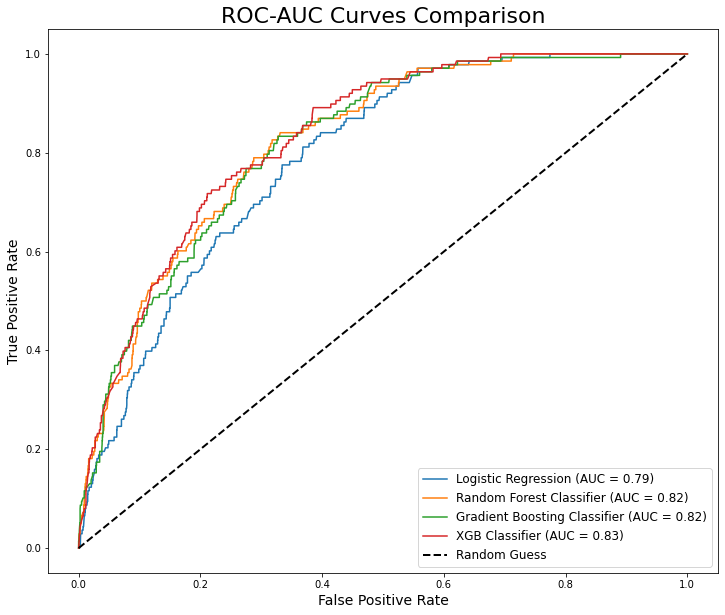

In [35]:
# plot the ROC-AUC curves of all the models
plot_roc_curves(test_models)

As seen from the ROC AUC curve, the logisitic regression model performed the worst out of all the models and the other three tree based models have roughly the same AUC score of 0.82 to 0.83. 

# Model Evaluation


**Summary of Results**

|                |            Models            | Train AUC | Test AUC | F-score |
|:--------------:|:----------------------------:|:---------:|:--------:|:-------:|
| Baseline Model |          BernoulliNB         |   0.765   |   0.740  |  0.159  |
|     Model 1    |      Logistic Regression     |   0.797   |   0.790  |  0.194  |
|     Model 2    |   Random Forest Classifier   |   0.894   |   0.823  |  0.252  |
|     Model 3    | Gradient Boosting Classifier |   0.901   |   0.819  |  0.274  |
|     Model 4    |      XGBoost Classifier      |   0.874   |   0.813  |  0.258  |

The best model from our testing is the Gradient Boosting Classifer model as seen from the result table above between Test AUC score and F-score. This could be because of the advantages of the Gradient Boosting Classifier model in which it is able to naturally handle of mixed data types, good predictive power and robustness to outliers. However, the hyperparameters are hard to tune and we can still observe overfitting for the model of our choice from the Train and Test AUC scores in the table above. This could be rectified in the future improvements. 

In [36]:
# Result list of baseline model
init_list

[{'model': 'nb',
  'train_auc': 0.765,
  'test_auc': 0.74,
  'precision': 0.09,
  'specificity': 0.592,
  'recall': 0.725,
  'f_score': 0.159}]

In [37]:
# Result list of the candidate models
gs_list

[{'model': 'lr',
  'train_auc': 0.797,
  'test_auc': 0.79,
  'precision': 0.112,
  'specificity': 0.677,
  'recall': 0.732,
  'f_score': 0.194},
 {'model': 'rf',
  'train_auc': 0.894,
  'test_auc': 0.823,
  'precision': 0.158,
  'specificity': 0.816,
  'recall': 0.623,
  'f_score': 0.252},
 {'model': 'gb',
  'train_auc': 0.901,
  'test_auc': 0.819,
  'precision': 0.19,
  'specificity': 0.883,
  'recall': 0.493,
  'f_score': 0.274},
 {'model': 'xgb',
  'train_auc': 0.874,
  'test_auc': 0.831,
  'precision': 0.157,
  'specificity': 0.789,
  'recall': 0.71,
  'f_score': 0.258}]

# Kaggle Submission

### Pre process the test data 

In [38]:
# drop date column
test.drop(columns = ['date'], inplace = True)

# change species column
minority_species = ['CULEX PIPIENS', 'CULEX PIPIENS/RESTUANS', 'CULEX RESTUANS']
test['species'] = test['species'].apply(lambda x: 'OTHERS' if x not in minority_species else x)

### Creating the dataframe for Kaggle submission

In [42]:
kaggle_pred = gb.predict(test)
kaggle_pred

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [43]:
# Reimport test dataset for ID Column
kaggle_df = pd.read_csv('data/test.csv')
kaggle_df = kaggle_df[['Id']]
kaggle_df['WnvPresent'] = kaggle_pred

In [44]:
kaggle_df.to_csv('data/kaggle_df.csv', index = False)

### Kaggle Results

For our best model of the Gradient Boosting Classifier, a public Kaggle score of 0.679 and a private Kaggle score of 0.666  was obtained.

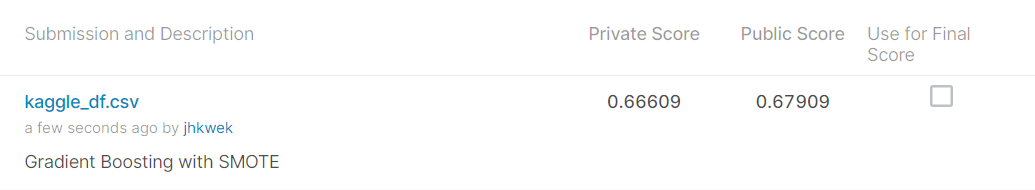

# Cost-Benefit Analysis

# Conclusion

### Limitation and Future Improvements

### Recommendations